In [33]:
# Randomized SVD
# Step 1: Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from tqdm import tqdm

In [35]:
# Step 2: Define the KolmogorovSolver class

class KolmogorovSolver:
    def __init__(self, N, viscosity, forcing_amplitude):
        # Initialize grid size, viscosity, and forcing amplitude
        self.N = N
        self.viscosity = viscosity
        self.forcing_amplitude = forcing_amplitude
        
        # Generate wave number grids
        self.kx = np.fft.fftfreq(N, 1.0 / N)
        self.ky = np.fft.fftfreq(N, 1.0 / N)
        self.kx, self.ky = np.meshgrid(self.kx, self.ky)
        self.k2 = self.kx ** 2 + self.ky ** 2
        self.k2[0, 0] = 1.0  # To avoid division by zero at k = 0

    def forcing(self):
        # Define external forcing (Kolmogorov forcing)
        return np.sin(4 * np.pi * self.ky / self.N)

    def time_step(self, u_hat, v_hat, dt):
        # Compute nonlinear terms
        u = np.real(ifft2(u_hat))
        v = np.real(ifft2(v_hat))
        u_x = np.real(ifft2(1j * self.kx * u_hat))
        u_y = np.real(ifft2(1j * self.ky * u_hat))
        v_x = np.real(ifft2(1j * self.kx * v_hat))
        v_y = np.real(ifft2(1j * self.ky * v_hat))
        
        nonlinear_u = u * u_x + v * u_y
        nonlinear_v = u * v_x + v * v_y

        # Update Fourier coefficients with nonlinear terms, viscosity, and forcing
        u_hat_new = (u_hat - dt * fft2(nonlinear_u)) / (1.0 + dt * self.viscosity * self.k2)
        v_hat_new = (v_hat - dt * fft2(nonlinear_v)) / (1.0 + dt * self.viscosity * self.k2)
        u_hat_new += dt * self.forcing()  # Add external forcing

        return u_hat_new, v_hat_new

    def solve(self, num_steps, dt):
        # Initialize Fourier coefficients for velocity components
        u_hat = np.zeros((self.N, self.N), dtype=np.complex128)
        v_hat = np.zeros((self.N, self.N), dtype=np.complex128)

        # Add small random perturbations to initial conditions
        u_hat += 0.01 * (np.random.randn(self.N, self.N) + 1j * np.random.randn(self.N, self.N))
        v_hat += 0.01 * (np.random.randn(self.N, self.N) + 1j * np.random.randn(self.N, self.N))

        # Arrays to store velocity fields over time
        u_data = []
        v_data = []
        
        # Time-stepping loop
        for _ in tqdm(range(num_steps)):
            u_hat, v_hat = self.time_step(u_hat, v_hat, dt)
            u = np.real(ifft2(u_hat))
            v = np.real(ifft2(v_hat))
            u_data.append(u)
            v_data.append(v)

        return np.array(u_data), np.array(v_data)

In [37]:
# Step 3: Set the solver parameters

N = 64  # Grid size (number of grid points in each dimension)
viscosity = 0.001  # Fluid viscosity
forcing_amplitude = 1.0  # Amplitude of the external forcing
num_steps = 500  # Number of time steps to simulate
dt = 0.01  # Time step size

# Initialize the Kolmogorov solver with the parameters
solver = KolmogorovSolver(N, viscosity, forcing_amplitude)

In [39]:
# Step 4: Run the solver to generate data

# Generate data for velocity fields u and v
u_data, v_data = solver.solve(num_steps, dt)

# Save the generated data to .npy files for later use
np.save('u_data.npy', u_data)
np.save('v_data.npy', v_data)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 477.38it/s]


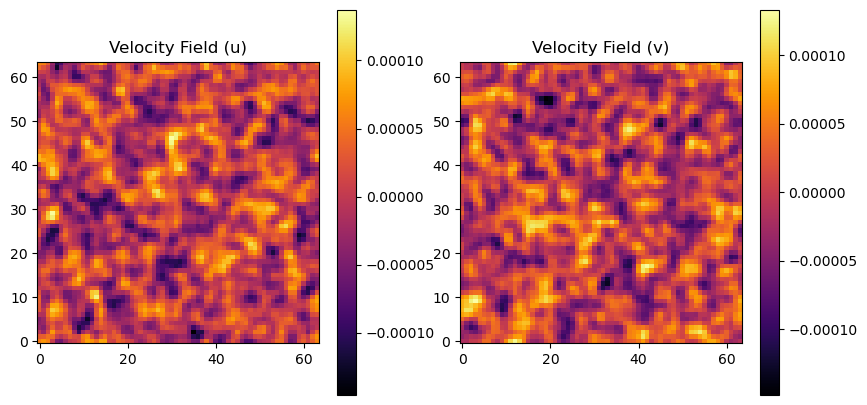

In [40]:
# Step 5: Visualize the results

plt.figure(figsize=(10, 5))

# Plot the u-velocity field
plt.subplot(1, 2, 1)
plt.title("Velocity Field (u)")
plt.imshow(u_data[-1], origin='lower', cmap='inferno')
plt.colorbar()

# Plot the v-velocity field
plt.subplot(1, 2, 2)
plt.title("Velocity Field (v)")
plt.imshow(v_data[-1], origin='lower', cmap='inferno')
plt.colorbar()

plt.show()

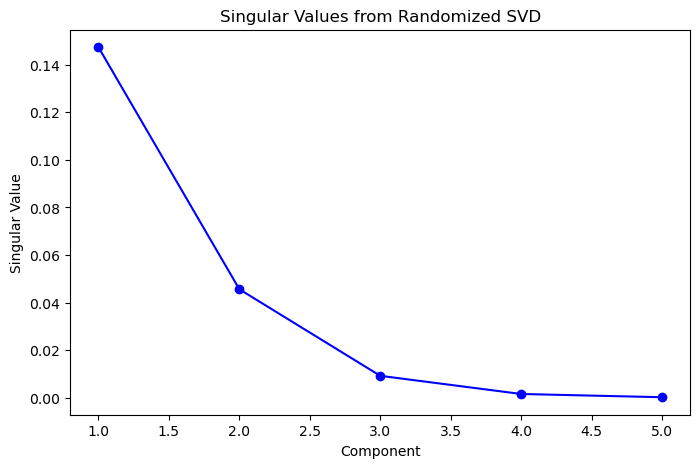

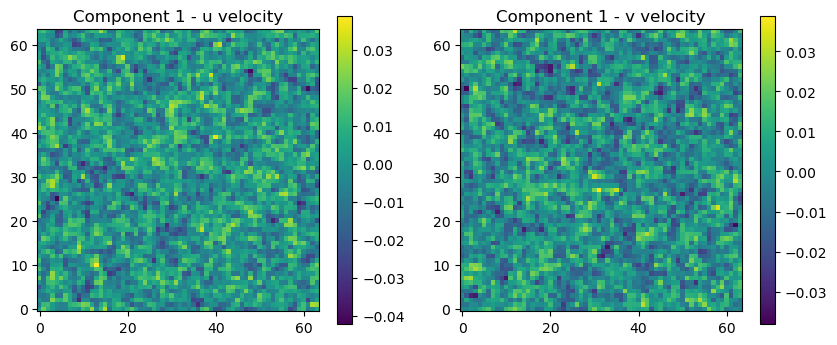

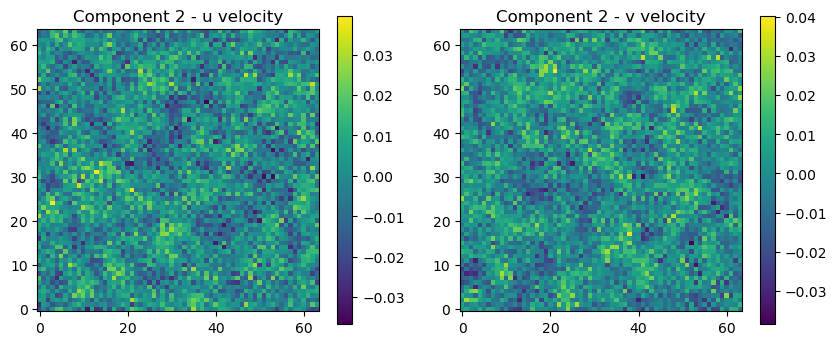

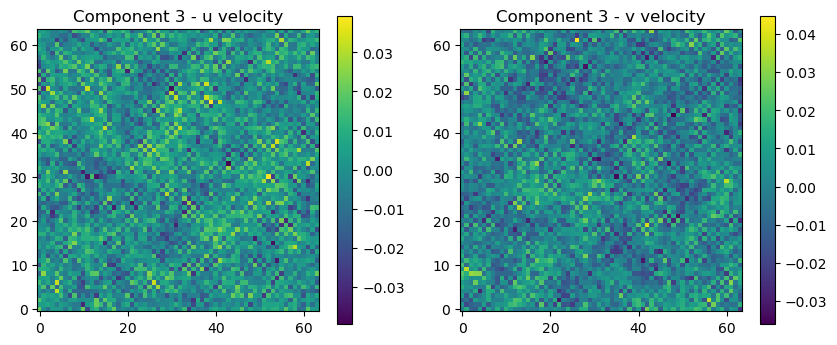

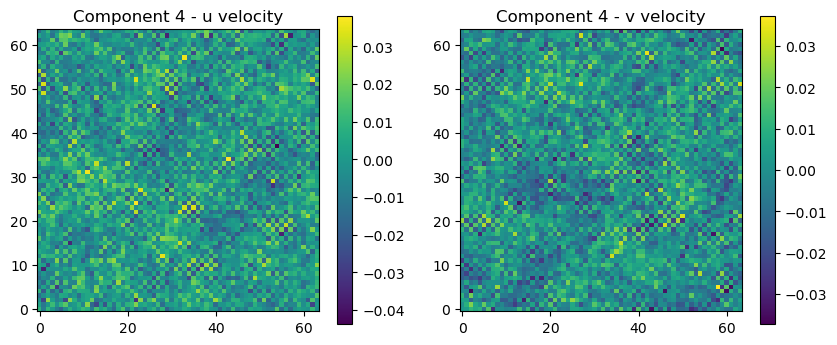

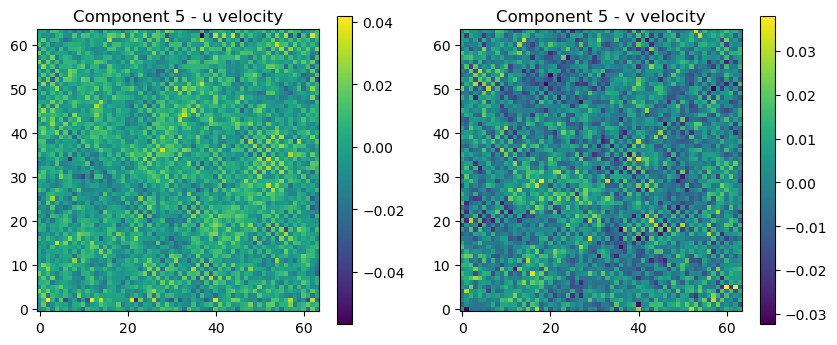

In [42]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Assuming `u_data` and `v_data` are lists of 2D arrays for each timestep in the velocity field
n_timesteps = len(u_data)  # Number of timesteps
grid_shape = u_data[0].shape  # Shape of each grid (assumed to be the same for all timesteps)
grid_size = grid_shape[0] * grid_shape[1]  # Total number of grid points

# Flatten each u and v field and stack them into a single data matrix
X = np.zeros((n_timesteps, 2 * grid_size))
for t in range(n_timesteps):
    X[t, :grid_size] = u_data[t].ravel()  # Flatten u-component and store in the first half
    X[t, grid_size:] = v_data[t].ravel()  # Flatten v-component and store in the second half

# Apply Randomized SVD (TruncatedSVD with n_components < min(n_samples, n_features))
n_components = 5  # Number of components to retain
svd = TruncatedSVD(n_components=n_components, random_state=0)
X_svd = svd.fit_transform(X)

# Plot the singular values to visualize the significance of each component
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, n_components + 1), svd.singular_values_, 'o-', color='b')
plt.title("Singular Values from Randomized SVD")
plt.xlabel("Component")
plt.ylabel("Singular Value")
plt.show()

# Visualize the first few principal components (modes) in the spatial domain
for i in range(n_components):
    # Reshape only the first grid_size elements to u and second grid_size to v
    u_component = svd.components_[i, :grid_size].reshape(grid_shape)
    v_component = svd.components_[i, grid_size:].reshape(grid_shape)
    
    # Plot the u-component
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Component {i+1} - u velocity")
    plt.imshow(u_component, origin='lower', cmap='viridis')
    plt.colorbar()
    
    # Plot the v-component
    plt.subplot(1, 2, 2)
    plt.title(f"Component {i+1} - v velocity")
    plt.imshow(v_component, origin='lower', cmap='viridis')
    plt.colorbar()
    
    plt.show()